In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import torch
from pathlib import Path
import copy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.8)

[PosixPath('../exp_data/test_exact/uci_elevators_baseline_gp/06.02.02.38.19/metrics.csv')]


Text(0, 0.5, 'test RMSE')

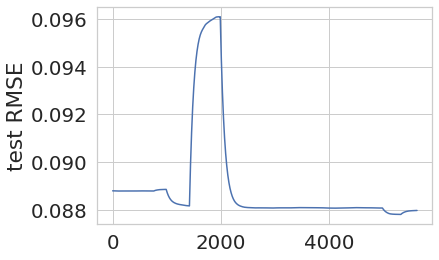

In [40]:
log_dir = Path('../exp_data/test_exact/uci_elevators_baseline_gp')
print([f for f in log_dir.rglob('metrics.csv')])
data = [pd.read_csv(f) for f in log_dir.rglob('metrics.csv')]
# data[0].columns
plt.plot(data[0].step, data[0].raw_test_rmse.ewm(span=16).mean())
# plt.yscale('log')
plt.ylabel('test RMSE')

In [92]:
def merge_trials(df_list, key, column):
    merged_df = df_list[0][[key, column]]
    for trial_df in df_list[1:]:
        merged_df = pd.merge_asof(merged_df, trial_df[[key, column]],
                                  on=key, direction='nearest')
    print(len(merged_df))
    return merged_df

def smooth_line(x, y, num_grid):
    interp_fn = interpolate.interp1d(x, y, kind='quadratic')
    grid = np.linspace(x[0], x[-1], num_grid)
    y_hat = interp_fn(grid)
    return grid, y_hat

def get_credible_region(x, region='gaussian'):
    mean, std = x.mean(0), x.std(0)
    if region == 'gaussian':
        lb, ub = mean - 2 * std, mean + 2 * std
    elif region == 'lognormal':
        mu = np.log(mean ** 2 / np.sqrt(mean ** 2 + std ** 2))
        sigma = np.sqrt(np.log(1 + std ** 2 / mean ** 2))
        lb = np.exp(mu - 2 * sigma)
        ub = np.exp(mu + 2 * sigma)
    else:
        raise RuntimeError('unrecognized region type')
    return lb, ub

def add_line(df_list, quantity, region_type, color, label, window, pretrain_ratio):
    df_list.sort(key=lambda x: len(x))
    merged_df = merge_trials(df_list, 'step', quantity)
    step_range = np.linspace(pretrain_ratio, 1., len(merged_df)) * 100
    values = merged_df.drop(columns=['step']).ewm(span=1000).mean().values.T
    mean = values.mean(0)
    lb, ub = get_credible_region(values, region_type)
    
#     x_grid, mean = smooth_line(step_range, mean, 2 * len(merged_df))
#     _, lb = smooth_line(step_range, lb, 2 * len(merged_df))
#     _, ub = smooth_line(step_range, ub, 2 * len(merged_df))
    
    plt.plot(step_range, mean, linewidth=4, label=label, color=color)
    plt.fill_between(step_range, lb, ub, alpha=0.25, color=color)

In [93]:
palette = sns.color_palette('bright')
ssgp_color = palette[0]
woodbury_color = palette[4]
ski_color = palette[2]
exact_color = palette[7]

dkl_benchmarks = {
    'uci_bike': {'test_rmse': 0.1185, 'target_std': 1.4861},
    'uci_elevators': {'test_rmse': 0.084, 'target_std': 0.2526},
    'uci_pol': {'test_rmse': 3.28, 'target_std': 41.7258},
    'uci_protein': {'test_rmse': 0.441, 'target_std': 0.7726},
    'uci_keggdirected': {'test_rmse': 0.11, 'target_std': 1.3756},
    'uci_keggundirected': {'test_rmse': 0.11, 'target_std': 0.9816},
    'uci_kin40k': {'test_rmse': 0.051, 'target_std': 0.9970},
    'uci_3droad': {'test_rmse': 6.91, 'target_std': 18.6180},
    'uci_skillcraft': {'test_rmse': 0.25, 'target_std': 0.6767},
    'uci_slice': {'test_rmse': 0.36, 'target_std': 22.3470},
    'uci_powerplant': {'test_rmse': 3.7, 'target_std': 17.06}
}

10


### NLL PLOT

479
479


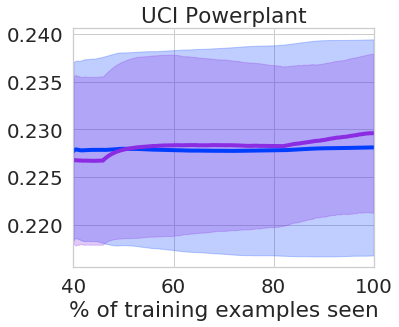

In [94]:
exp_name = 'dkl_sweep'
sweep_params = 'hidden_dim-512_pretrain_ratio-0.4'
task_name = 'uci_powerplant'
quantity = 'test_rmse'
region_type = 'gaussian'

fig = plt.figure(figsize=(6, 5))
_, title = task_name.split('_', 1)
plt.title(f"UCI {title.capitalize()}")

log_dir = Path('../exp_data') / exp_name / (task_name + '_online_svgp') / sweep_params
svgp_dfs = [pd.read_csv(f) for f in log_dir.rglob('metrics.csv')]
add_line(svgp_dfs, quantity, region_type, color=ssgp_color, label='O-SVGP (online)', window=16, pretrain_ratio=0.4)

log_dir = Path('../exp_data') / exp_name / (task_name + '_online_ski') / sweep_params
wiski_dfs = [pd.read_csv(f) for f in log_dir.rglob('metrics.csv')]
add_line(wiski_dfs, quantity, region_type, color=woodbury_color, label='WISKI (online)', window=16, pretrain_ratio=0.4)

# log_dir = Path('../exp_data') / exp_name / (task_name + '_baseline_gp')
# exact_dfs = [pd.read_csv(f) for f in log_dir.rglob('metrics.csv')]
# add_line(exact_dfs, quantity, region_type, color=palette[1], label='Exact (online)', window=16, pretrain_ratio=0.5)

# plt.hlines(dkl_benchmarks[task_name]['test_rmse'], *plt.xlim(), color='black', linewidth=4, linestyle='--', label='Batch DKL')
# plt.hlines(dkl_benchmarks[task_name]['target_std'], *plt.xlim(), color='grey', linewidth=4, linestyle='--')

y_label = quantity.split('_')[-1].upper()
# plt.ylabel("Test " + y_label)
plt.xlim((40, 100))

# plt.yscale('log')
# plt.ylim((0.54, 0.62))

# plt.legend(fontsize='small')
# plt.legend(ncol=2, bbox_to_anchor=(0.1, -0.5, 1., 0.2))
plt.xlabel('% of training examples seen')
plt.tight_layout()

# plt.savefig(f'dkl_elevators_test_rmse.pdf')

747
2058
1800
2198


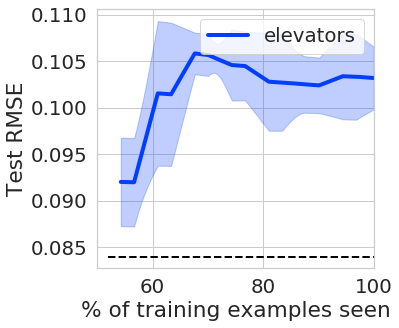

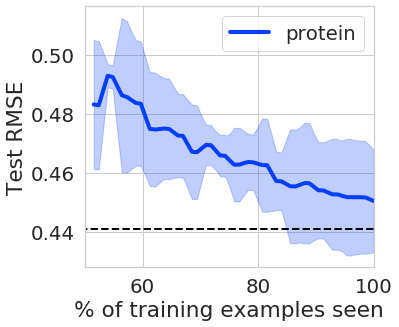

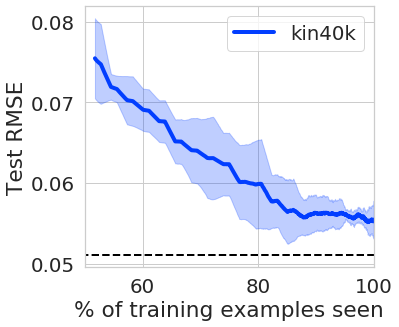

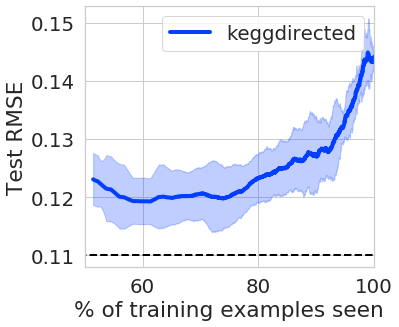

In [85]:
def make_dkl_plot(log_dir, task_name, quantity, region_type):
    
    df_list = [pd.read_csv(f) for f in log_dir.rglob('metrics.csv')]
    
    fig = plt.figure(figsize=(6, 5))
    _, label = task_name.split('_', 1)
    add_line(df_list, quantity, region_type, color=palette[0], label=label, window=64, pretrain_ratio=0.5)
    plt.hlines(dkl_baselines[task_name], *plt.xlim(), color='black', linewidth=2, linestyle='--')
    
    plt.ylabel('Test RMSE')
    plt.xlim((50, 100))
    plt.legend()
    plt.xlabel('% of training examples seen')
    plt.tight_layout()
    

task_name = 'uci_protein'
log_dir = Path('../exp_data') / exp_name / f'{task_name}_online_ski'
make_dkl_plot('uci_elevators', 'raw_test_rmse', 'gaussian')
make_dkl_plot('uci_protein', 'raw_test_rmse', 'gaussian')
make_dkl_plot('uci_kin40k', 'raw_test_rmse', 'gaussian')
make_dkl_plot('uci_keggdirected', 'raw_test_rmse', 'lognormal')

# plt.savefig('dkl_uci_protein_50.pdf')

### DKL UCI Test MSE

Text(0.5, 0, '% of training examples seen')

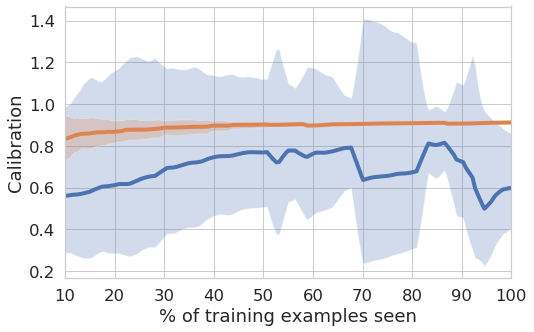

In [9]:
quantity = 'calibration_0.95'
region_type = 'lognormal'
fig = plt.figure(figsize=(8, 5))
add_line(elevator_dfs, quantity, region_type, color=palette[0], label='elevators', window=32)
add_line(protein_dfs, quantity, region_type, color=palette[1], label='protein', window=32)
# add_line(keggd_dfs, quantity, region_type, color=palette[2], label='kegg-d', window=32)

plt.ylabel("Calibration")
plt.xlim((10, 100))
plt.xlabel('% of training examples seen')

In [10]:
exp_name = 'test_freqdir'
log_dir = Path('../exp_data/') / exp_name

true_fn = 'sine'
model_types = ['online_ski', 'online_svgp']
metrics = {}
for m_type in model_types:
    subdir = log_dir / f"{true_fn}_{m_type}"
    saved_metrics = [torch.load(f) for f in subdir.rglob('*.dat')]
    metrics[m_type] = saved_metrics
    print(len(saved_metrics))
    
woodbury_true_mse = metrics['online_ski'][0]['true_mse'].cpu()
ssgp_true_mse = metrics['online_svgp'][0]['true_mse'].cpu()
# baseline_time = metrics['baseline_gp'][0]['time']
# ski_time = metrics['ski_gp'][0]['time']

woodbury_time = metrics['online_ski'][0]['time']
ssgp_time = metrics['online_svgp'][0]['time']

1
1


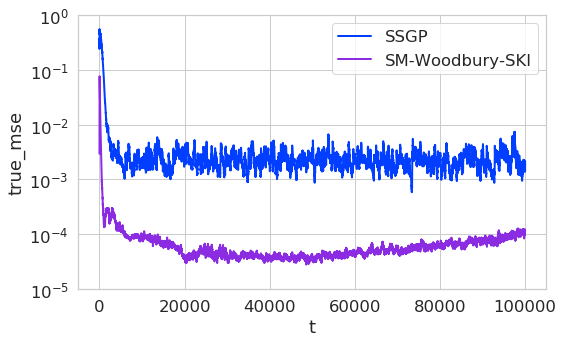

In [13]:
span = 256
# ski_true_mse_smooth = pd.Series(ski_true_mse).ewm(span=span).mean()
# baseline_true_mse_smooth = pd.Series(baseline_true_mse).ewm(span=span).mean()
woodbury_true_mse_smooth = pd.Series(woodbury_true_mse).ewm(span=span).mean()
ssgp_true_mse_smooth = pd.Series(ssgp_true_mse).ewm(span=span).mean()

# window_size = 1
# ski_true_mse_smooth = pd.Series(ski_true_mse).rolling(window_size).mean()
# baseline_true_mse_smooth = pd.Series(baseline_true_mse).rolling(window_size).mean()
# woodbury_true_mse_smooth = pd.Series(woodbury_true_mse).rolling(window_size).mean()
# ssgp_true_mse_smooth = pd.Series(ssgp_true_mse).rolling(window_size).mean()

fig = plt.figure(figsize=(8, 5))

# xmin, xmax = -2000, 100000
# plt.xlim((xmin, xmax))
# plt.hlines(y=0.1, xmin=xmin, xmax=xmax, color='red', linestyle='dotted', linewidth=4)

plt.plot(ssgp_true_mse_smooth, label='SSGP', linewidth=2, color=ssgp_color)
plt.plot(woodbury_true_mse_smooth, label='SM-Woodbury-SKI', linewidth=2, color=woodbury_color)
# plt.plot(ski_true_mse_smooth, label='SKI', linewidth=4, color=ski_color)
# plt.plot(baseline_true_mse_smooth, label='Exact', linewidth=4, linestyle='--', color=exact_color)

plt.xlabel('t')
plt.ylabel('true_mse')
# plt.title('cumulative regret')
plt.legend()

plt.tight_layout()

plot_data = {
    'ssgp_true_mse': ssgp_true_mse,
    'sm_woodbury_ski_true_mse': woodbury_true_mse,
#     'ski_true_mse': ski_true_mse,
#     'exact_true_mse': baseline_true_mse,
    'smoothing_span': span
}
# plt.title('CPU Timing')
plt.yscale('log')
plt.ylim((1e-5, 1))

fig_name = 'online_regression_long_true_mse'
# plt.savefig(fig_name + '.pdf')
# torch.save(plot_data, fig_name + '.dat')

In [ ]:
span = 256
ski_mse_smooth = pd.Series(ski_mse).ewm(span=span).std()
baseline_mse_smooth = pd.Series(baseline_mse).ewm(span=span).std()
woodbury_mse_smooth = pd.Series(woodbury_mse).ewm(span=span).std()
ssgp_mse_smooth = pd.Series(ssgp_mse).ewm(span=span).std()

fig = plt.figure(figsize=(8, 5))

xmin, xmax = 0, 5000
plt.xlim((xmin, xmax))
# plt.hlines(y=0.1, xmin=xmin, xmax=xmax, color='red', linestyle='dotted', linewidth=4)

plt.plot(ssgp_mse_smooth, label='SSGP', linewidth=2, color=ssgp_color)
plt.plot(woodbury_mse_smooth, label='SM-Woodbury-SKI', linewidth=2, color=woodbury_color)
plt.plot(ski_mse_smooth, label='SKI', linewidth=4, color=ski_color)
plt.plot(baseline_mse_smooth, label='Exact', linewidth=4, linestyle='--', color=exact_color)

plt.xlabel('t')
plt.ylabel('mse std')
plt.legend(loc='upper right')

plt.tight_layout()

### REGRET PLOT

In [ ]:
exp_name = 'cpu_timing'
log_dir = Path('../exp_data/') / exp_name

true_fn = 'sine'
model_types = ['variational_gp', 'online_gp', 'baseline_gp', 'ski_gp']

metrics = {}
for m_type in model_types:
    subdir = log_dir / f"{true_fn}_{m_type}"
    saved_metrics = [torch.load(f) for f in subdir.rglob('*.dat')]
    metrics[m_type] = saved_metrics
    print(len(saved_metrics))

In [ ]:
baseline_time = metrics['baseline_gp'][0]['time']
ski_time = metrics['ski_gp'][0]['time']
ski_mse = metrics['ski_gp'][0]['mse']
ski_nll = metrics['ski_gp'][0]['nll']
baseline_mse = metrics['baseline_gp'][0]['mse']
baseline_nll = metrics['baseline_gp'][0]['nll']

In [ ]:
woodbury_regret = metrics['online_gp'][0]['nll_regret']
ssgp_regret = metrics['variational_gp'][0]['nll_regret']
baseline_regret = metrics['baseline_gp'][0]['nll_regret']
ski_regret = metrics['ski_gp'][0]['nll_regret']

fig = plt.figure(figsize=(8, 5))
plt.plot(ssgp_regret, label='SSGP', linewidth=4, color=ssgp_color)
plt.plot(woodbury_regret, label='SM-Woodbury-SKI', linewidth=4, color=woodbury_color)
plt.plot(ski_regret, label='SKI', linewidth=4, color=ski_color)
plt.plot(baseline_regret, label='Exact', linewidth=4, linestyle='--', color=exact_color)

plt.xlabel('t')
plt.ylabel('regret')
# plt.title('cumulative regret')
plt.legend(loc='upper left')
plt.tight_layout()

regret_plot_data = {
    'ssgp_regret': ssgp_regret,
    'sm_woodbury_ski_regret': woodbury_regret,
    'ski_regret': ski_regret,
    'exact_regret': baseline_regret
}

# plt.savefig('sm_woodbury_ski_regret.pdf')
# torch.save(regret_plot_data, 'sm_woodbury_ski_regret.dat')

### TIMING PLOT

In [ ]:
woodbury_time = metrics['online_gp'][0]['time']
ssgp_time = metrics['variational_gp'][0]['time']
baseline_time = metrics['baseline_gp'][0]['time']
ski_time = metrics['ski_gp'][0]['time']

window_size = 4
ski_time_smooth = pd.Series(ski_time).rolling(window_size).mean()
baseline_time_smooth = pd.Series(baseline_time).rolling(window_size).mean()
woodbury_time_smooth = pd.Series(woodbury_time).rolling(window_size).mean()
ssgp_time_smooth = pd.Series(ssgp_time).rolling(window_size).mean()

fig = plt.figure(figsize=(8, 5))
# log_t = [num_old + t for t in range(baseline_cum_regret.shape[0])]

plt.plot(ssgp_time_smooth, label='SSGP', linewidth=4, color=ssgp_color)
plt.plot(woodbury_time_smooth, label='SM-Woodbury-SKI', linewidth=4, color=woodbury_color)
plt.plot(ski_time_smooth, label='SKI', linewidth=4, color=ski_color)
plt.plot(baseline_time_smooth, label='Exact', linewidth=4, linestyle='--', color=exact_color)

plt.xlabel('t')
plt.ylabel('wallclock time')
# plt.yscale('log')
# plt.title('cumulative regret')
plt.legend(loc='upper left')
plt.xlim((0, 4200))
plt.tight_layout()

time_plot_data = {
    'ssgp_time': ssgp_time,
    'sm_woodbury_ski_time': woodbury_time,
    'ski_time': ski_time,
    'exact_time': baseline_time,
    'smoothing_window_size': window_size
}
plt.yscale('log')
# plt.title('CPU Timing')

# plt.savefig('sm_woodbury_ski_time_cpu.pdf')
# torch.save(time_plot_data, 'sm_woodbury_ski_time_cpu.dat')

### NUM_INDUCING ABLATION

In [ ]:
log_dir = Path('../exp_data/num_inducing_ablation/sine_online_gp/')

metric_files = log_dir.rglob('*.dat')
cfg_files = log_dir.rglob('*.yaml')

exp_data = {}
for m_file, c_file in zip(metric_files, cfg_files):
    m_stamp = m_file.as_posix().split('/')[-2]
    c_stamp = c_file.as_posix().split('/')[-2]
    exp_data.setdefault(m_stamp, {})
    exp_data.setdefault(c_stamp, {})
    exp_data[m_stamp]['metrics'] = torch.load(m_file.as_posix())
    exp_data[c_stamp]['config'] = torch.load(c_file.as_posix())

In [ ]:
fig = plt.figure(figsize=(8, 5))

plot_data = [(
    record['metrics']['nll_regret'].cpu(),
    int(record['config']['online_gp']['num_inducing'])
) for record in exp_data.values()]
plot_data.sort(key=lambda x: x[1], reverse=True)

for i, (data, label) in enumerate(plot_data):
    plt.plot(data, label=label, color=palette[i])
    
plt.ylabel('regret')
plt.xlabel('t')
plt.xlim((0, 4200))
plt.legend()
plt.tight_layout()

# torch.save(plot_data, "num_inducing_ablation.dat")
# plt.savefig("num_inducing_ablation.pdf")